## Import libraries

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import skew

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb

## Load data

In [182]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
ID = pd.DataFrame({'Id': df_test["Id"].values})

In [183]:
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [184]:
df_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

## Remove outliers

In [185]:
df_train = df_train[~((df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000))]

## Make all dataset (concatenate train set and test set)

In [186]:
df_all = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'], df_test.loc[:,'MSSubClass':'SaleCondition']))

## Feature Engineering

In [187]:
# Merge Porch infomation
df_all['TotalHousePorchSF'] = df_all['EnclosedPorch']+df_all['OpenPorchSF']+df_all['WoodDeckSF']+df_all['3SsnPorch']+df_all['ScreenPorch']
df_train['TotalHousePorchSF'] = df_train['EnclosedPorch']+df_train['OpenPorchSF']+df_train['WoodDeckSF']+df_train['3SsnPorch']+df_train['ScreenPorch']

# Total Floor Square Feet
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

# Squred Overall Quality because Overall Quality is the most correlated
df_all['OverallQual_2'] = df_all['OverallQual']**2
df_train['OverallQual_2'] = df_train['OverallQual']**2

## Check the Multicollinearity

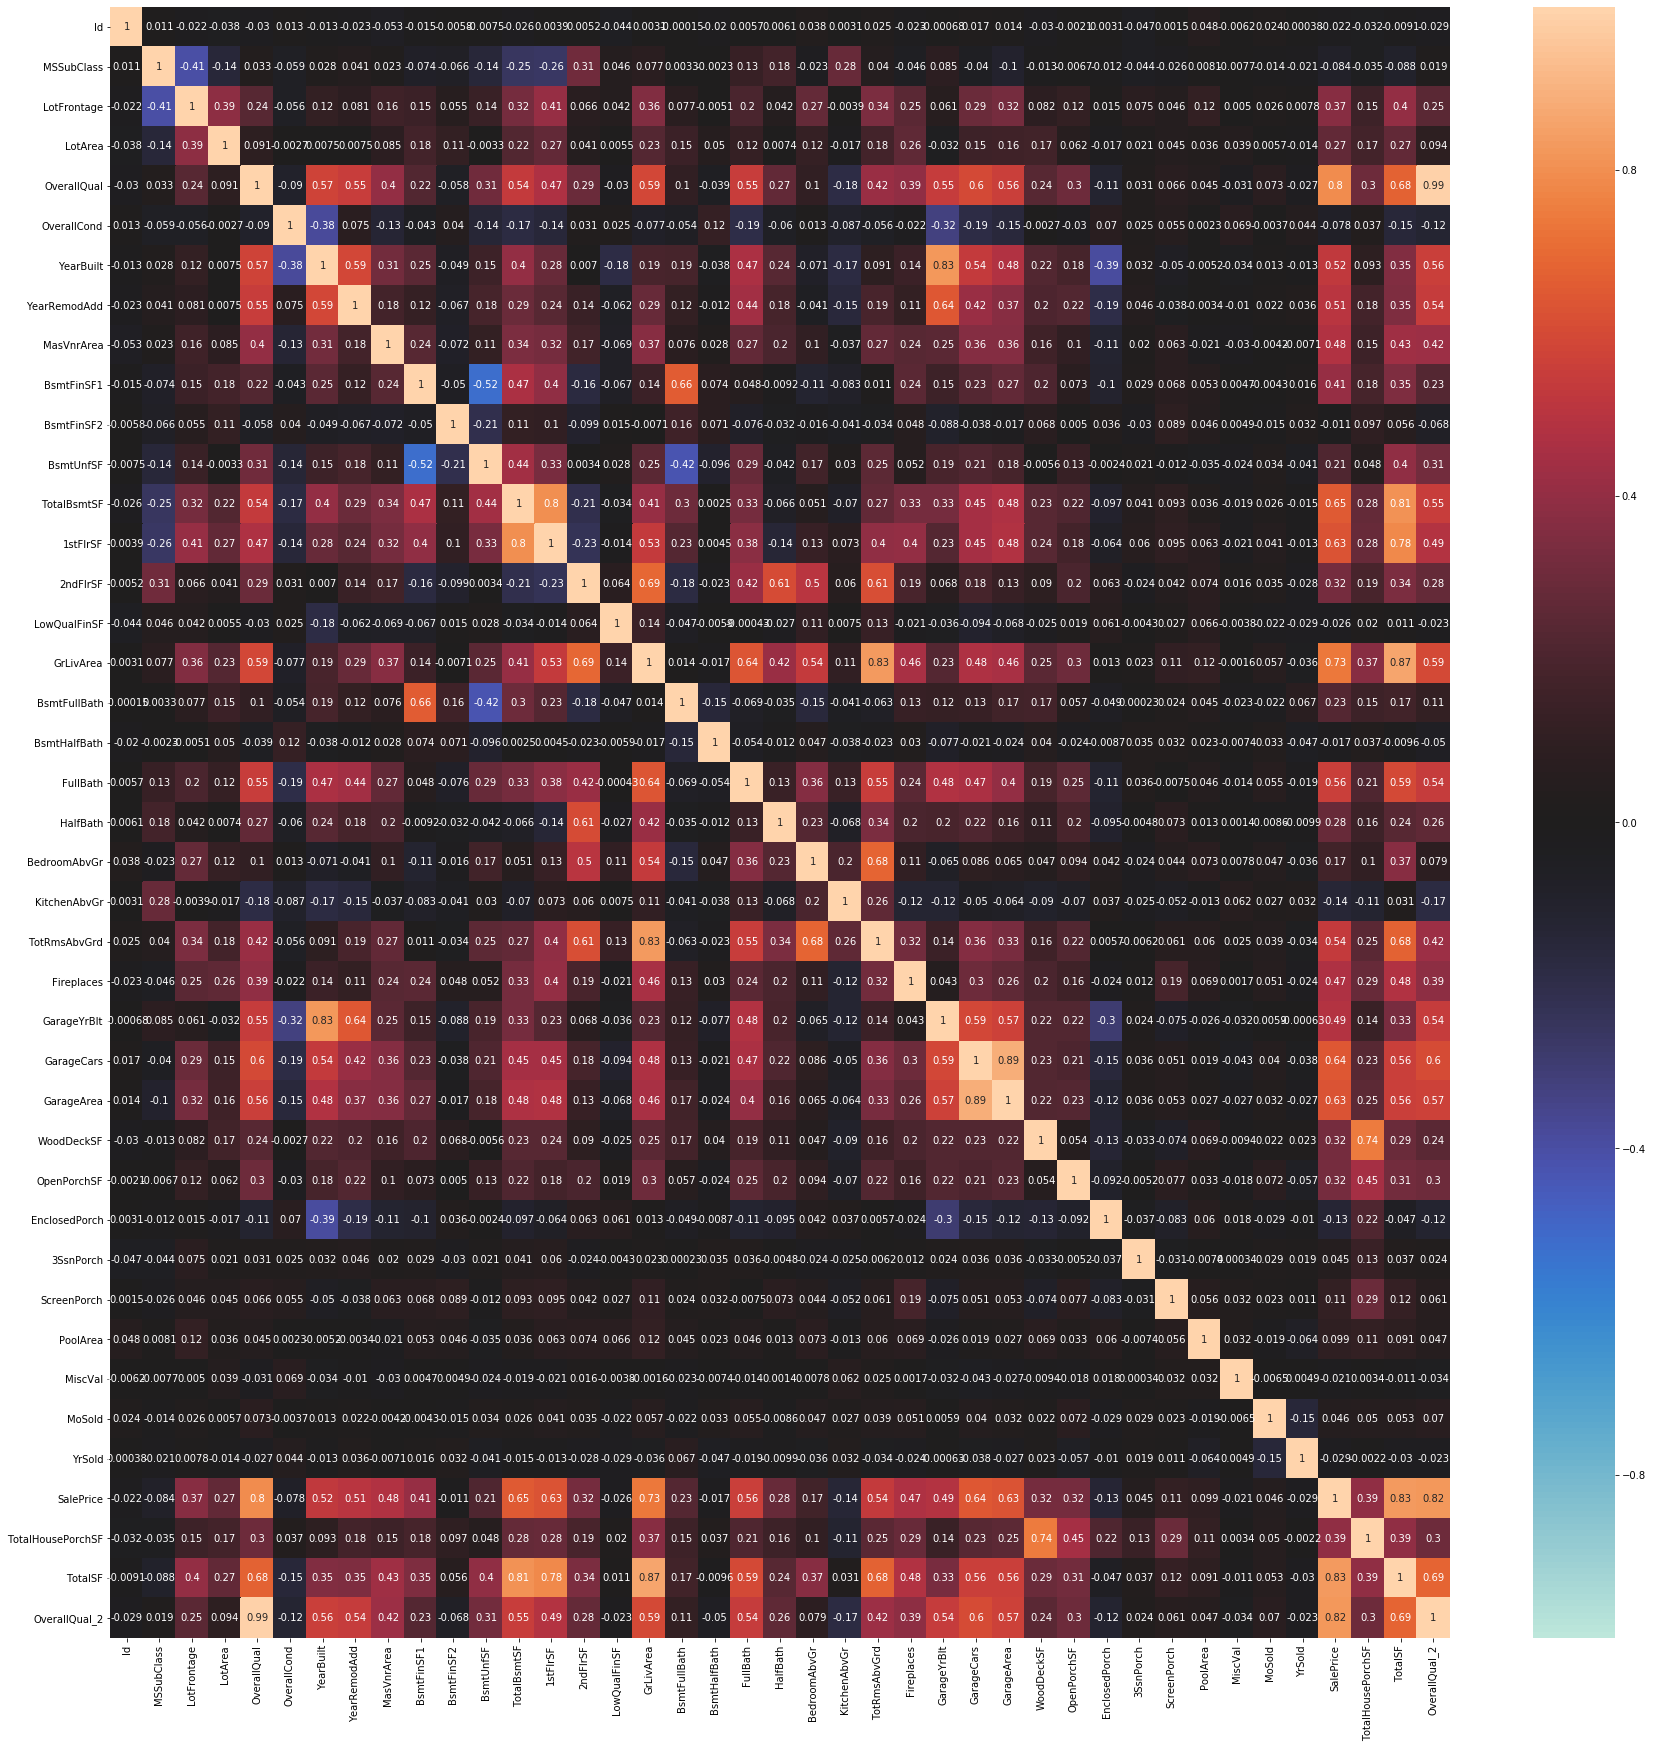

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(df_train.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

There are 4 pairs which are highly correlated. We remove the one of the pair, which is less correralted with 'SalePrice'.

In [189]:
df_all.drop(['1stFlrSF','GarageArea','TotRmsAbvGrd', 'GarageYrBlt'], axis=1, inplace=True)

## Nomarize the numerical featrures

### 1. First, the target feature 'SalePrice'

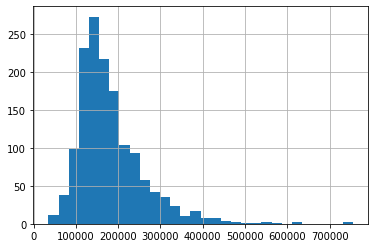

In [190]:
df_train["SalePrice"].hist(bins=30)

As we can see, the skewness is quite high. Thus, we apply log-transformation to the variable.

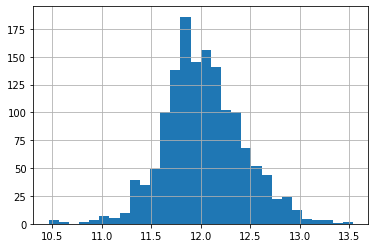

In [191]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

# Check the distribution
df_train["SalePrice"].hist(bins=30)

### 2. Next, the other numerical features

Apply log-transformation if the skewness is higher than 0.6

In [192]:
non_categoricals = df_all.dtypes[df_all.dtypes != "object"].index
skewed_feats = df_train[non_categoricals].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.6].index

df_all[skewed_feats] = np.log1p(df_all[skewed_feats])

## Replace missing data

In [193]:
df_all = df_all.fillna(df_all.mean())

## Make dummy features for categorical data

In [194]:
df_all = pd.get_dummies(df_all)

# Modeling ------------------------------------------------------------------------------

In [195]:
X = df_all[:df_train.shape[0]]
X_for_test = df_all[df_train.shape[0]:]
y = df_train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)

In [196]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_rmse(model, X = X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

## Lasso

In [197]:
lasso = Lasso(alpha=0.0005, max_iter=10000)

score = cv_rmse(lasso, X = X)
print("LASSO: {:.4f} \n".format(score.mean(), score.std()))

LASSO: 0.1108 



## Elastic Net

In [198]:
enet = make_pipeline(RobustScaler(), ElasticNet(max_iter=1000, alpha=0.0007, l1_ratio=.9, random_state=3))

score = cv_rmse(enet)
print("elastic net: {:.4f}\n".format(score.mean(), score.std()) )

elastic net: 0.1101



## Ridge 

In [199]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha=15))
score = cv_rmse(ridge)
print("elastic net: {:.4f}\n".format(score.mean(), score.std()) )

elastic net: 0.1118



## SVR 

In [103]:
svr = make_pipeline(RobustScaler(), 
                    SVR(C = 30, epsilon= 0.005, gamma=0.0003))
score = cv_rmse(svr)
print("SVR: {:.4f}\n".format(score.mean(), score.std()))

SVR: 0.1109



## GBoost

In [108]:
gboost = GradientBoostingRegressor(n_estimators=5000, 
                                learning_rate=0.01, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=15, 
                                min_samples_split=10, 
                                loss='huber', 
                                random_state =42) 
score = cv_rmse(gboost)
print("gboost: {:.4f}\n".format(score.mean(), score.std()) )

gboost: 0.1130



## lightGBM

In [110]:
lightgbm = lgb.LGBMRegressor(objective='regression', 
                             num_leaves=4,
                             learning_rate=0.015, 
                           n_estimators=5000,
                           max_bin=200, 
                           bagging_fraction=0.75,
                           bagging_freq=5, 
                           bagging_seed=7,
                           feature_fraction=0.2,
                           feature_fraction_seed=7,
                           verbose=-1)

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f}\n".format(score.mean(), score.std()) )

lightgbm: 0.1157



## XGBoost

In [115]:
xgboost = xgb.XGBRegressor(learning_rate=0.01,
                           n_estimators = 5000,
                           max_depth=3, 
                           min_child_weight=0,   
                           gamma=0, 
                           subsample=0.7,
                           colsample_bytree=0.7,
                           objective='reg:linear',
                           reg_alpha=0.00006)

score = cv_rmse(xgboost)
print("xgboost: {:.4f}\n".format(score.mean(), score.std()) )

xgboost: 0.1137



# Stacking

In [131]:
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=5, shuffle=True, random_state=71)
    
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        # fitting training data
        model.fit(tr_x, tr_y)
        # predict validation data & store prediction of validation
        pred = model.predict(va_x)
        preds.append(pred)
        
        # predict validation data & store prediction of validation
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        
        # remember the index of folds to concatenate dataframe later
        va_idxes.append(va_idx)

    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [132]:
print('Ridge')
pred_train_ridge, pred_test_ridge = predict_cv(ridge, X, y, X_for_test)
print(rmsle(y, pred_train_ridge))

print('Lasso')
pred_train_lasso, pred_test_lasso = predict_cv(lasso, X, y, X_for_test)
print(rmsle(y, pred_train_lasso))

print('ENet')
pred_train_enet, pred_test_enet = predict_cv(enet, X, y, X_for_test)
print(rmsle(y, pred_train_enet))

print('SVR')
pred_train_svr, pred_test_svr = predict_cv(svr, X, y, X_for_test)
print(rmsle(y, pred_train_svr))

print('GBoost')
pred_train_gboost, pred_test_gboost = predict_cv(gboost, X, y, X_for_test)
print(rmsle(y, pred_train_gboost))

print('XGBoost')
pred_train_xgboost, pred_test_xgboost = predict_cv(xgboost, X, y, X_for_test)
print(rmsle(y, pred_train_xgboost))

print('lightGBM')
pred_train_lightgbm, pred_test_lightgbm = predict_cv(lightgbm, X, y, X_for_test)
print(rmsle(y, pred_train_lightgbm))

Ridge
0.11134672554858467
Lasso
0.11013431996504111
ENet
0.10984586733188975
SVR
0.11048354268387078
GBoost
0.11369386575268398
XGBoost
0.11302089625192001
lightGBM
0.11468720724009426


In [133]:
X_train_stack = pd.DataFrame({'pred_ridge': pred_train_ridge, 'pred_lasso': pred_train_lasso,
                              'pred_enet': pred_train_enet, 'pred_svr': pred_train_svr,
                              'pred_gboost': pred_train_gboost, 'pred_xgboost': pred_train_xgboost,
                              'pred_lightgbm': pred_train_lightgbm})
X_for_test_stack = pd.DataFrame({'pred_ridge': pred_test_ridge, 'pred_lasso': pred_test_lasso,
                              'pred_enet': pred_test_enet, 'pred_svr': pred_test_svr,
                              'pred_gboost': pred_test_gboost, 'pred_xgboost': pred_test_xgboost,
                              'pred_lightgbm': pred_test_lightgbm})

In [134]:
pred_train_2, pred_test_2 = predict_cv(ridge, X_train_stack, y, X_for_test_stack)
print(rmsle(y, pred_train_2))
pred_test_2 = np.expm1(pred_test_2)

0.10751140699201074


In [124]:
solution = pd.DataFrame({'SalePrice': pred_test_2 })
solution = pd.concat([ID, solution], axis=1)

q1 = solution['SalePrice'].quantile(0.005)
q2 = solution['SalePrice'].quantile(0.995)
solution['SalePrice'] = solution['SalePrice'].apply(lambda x: x if x > q1 else x*0.97)
solution['SalePrice'] = solution['SalePrice'].apply(lambda x: x if x < q2 else x*1.03)

solution.to_csv("../submission/submission.csv", index = False)